# Optional Lab: SAR and Ice

# Introduction


Synthetic Aperture Radar (SAR) is an active sensor that transmits microwaves and measures the amount of signal that is returned to the sensor. The sensor can be airborne, but is more commonly spaceborne in the current times. SAR is collected on the X-, C-, and L-bands, with varying penetrative depths which dictate the utility (and interpretation of the imagery.


Many figures in this lab come from *Flores-Anderson, A.I., Herndon, K.E., Thapa, R.B. and Cherrington, E., 2019. The SAR Handbook: Comprehensive Methodologies for Forest Monitoring and Biomass Estimation.*

# Imports, installation, authentication, initialization

First and foremost, set up the notebook, as we have done in previous labs.



In [1]:
# Import the necessary libraries
import ee
import numpy as np
import geemap as geemap
import pprint

####pp = pprint.PrettyPrinter(depth=3)

In [2]:

# Authenticate and initialize this instance of GEE in Google Colab
# Follow the prompts and fill in authentication code
ee.Authenticate()
ee.Initialize(project='ee-cptcitrus-main')  #you will need to change this to your own earth engine project

## Useful Functions

Before we get too far, we need to define some functions for later use. We will call them to perform certains analysis on the imagery by calling the function and passing it (mostly) an image or a set of images. Have a look at the code to see if you can follow the logic of the functions, but you are NOT required to know the particulars of each function.

In [3]:
## Group of functions contrbuting to the Lee Filter
# Function to convert from dB
def toNatural(img):
    return ee.Image(10.0).pow(img.select(0).divide(10.0))

# Function to convert to dB
def toDB(img):
    return ee.Image(img).log10().multiply(10.0)

# The Lee filter is a commonly used filter for SAR imagery, for discussion under the Backscatter section
# Below the Lee Filter is provided as coded in the SNAP 3.0 S1TBX:
# see:  https:#earth.esa.int/documents/653194/656796/Speckle_Filtering.pdf
# and https://github.com/senbox-org/s1tbx/blob/master/s1tbx-op-sar-processing/src/main/java/org/esa/s1tbx/sar/gpf/filtering/SpeckleFilters/RefinedLee.java
# Adapted by Guido Lemoine

# uses directional masks to determine the most homogeneous part of
# the sliding window where local statistics have to be estimated

########## Lee filter
def RefinedLee(img):
    # img must be in natural units, i.e. not in dB!
    # Set up 3x3 kernels

    # convert to natural.. do not apply function on dB!
    # our images are in dB so we need to apply the toNatural algorithm
    myimg = toNatural(img)

    weights3 = ee.List.repeat(ee.List.repeat(1,3),3)  #this sets all pixels in window to weight of 1
    kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False) #this creates a 3x3 window

    mean3 = myimg.reduceNeighborhood(ee.Reducer.mean(), kernel3) #this smooths the image using a 3x3 window and calculating the mean for those pixels
    variance3 = myimg.reduceNeighborhood(ee.Reducer.variance(), kernel3) #this calculates the variance of each pixel in a 3x3 window - will highlight edges/texture

    # Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
    sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]])

    sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False)

    # Calculate mean and variance for the sampled windows and store as 9 bands
    sample_mean = mean3.neighborhoodToBands(sample_kernel)
    sample_var = variance3.neighborhoodToBands(sample_kernel)

    # Determine the 4 gradients for the sampled windows
    gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
    gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs())
    gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs())
    gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs())

    # And find the maximum gradient amongst gradient bands
    max_gradient = gradients.reduce(ee.Reducer.max())

    # Create a mask for band pixels that are the maximum gradient
    gradmask = gradients.eq(max_gradient)

    # duplicate gradmask bands: each gradient represents 2 directions
    gradmask = gradmask.addBands(gradmask)

    # Determine the 8 directions
    directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1)
    directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2))
    directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3))
    directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4))
    # The next 4 are the not() of the previous 4
    directions = directions.addBands(directions.select(0).Not().multiply(5))
    directions = directions.addBands(directions.select(1).Not().multiply(6))
    directions = directions.addBands(directions.select(2).Not().multiply(7))
    directions = directions.addBands(directions.select(3).Not().multiply(8))

    # Mask all values that are not 1-8
    directions = directions.updateMask(gradmask)

    # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
    directions = directions.reduce(ee.Reducer.sum())

    sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))

    # Calculate localNoiseVariance
    sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0])

    # Set up the 7*7 kernels for directional statistics
    rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4))

    diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0],
                            [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]])

    rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False)
    diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False)

    # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
    dir_mean = myimg.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1))
    dir_var = myimg.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1))

    dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)))
    dir_var= dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)))

    # and add the bands for rotated kernels
    for i in range(1,4):
        dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_mean = dir_mean.addBands(myimg.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
        dir_var = dir_var.addBands(myimg.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

    # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
    dir_mean = dir_mean.reduce(ee.Reducer.sum())
    dir_var= dir_var.reduce(ee.Reducer.sum())

    # A finally generate the filtered value
    varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))

    b = varX.divide(dir_var)

    result = dir_mean.add(b.multiply(myimg.subtract(dir_mean)))
    #return(result)
    return(img.addBands(ee.Image(toDB(result.arrayGet(0))).rename("filter")))
    #end of function

In [4]:
# This function looks at layover, foreshortening, and shadowing, explained in the section on Ascending vs Descending
import math

# This function identifies area of layover and shadow, and performs terrain correction based on the Arctic DEM
# This script is adapted from an implementation by Andreas Vollrath (ESA)
def terrainCorrection(image):
  imgGeom = ee.Geometry(image.geometry())
  srtm = ee.Image('UMN/PGC/ArcticDEM/V3/2m_mosaic').clip(imgGeom) # 2m ArcticDEM
  sigma0Pow = ee.Image.constant(10).pow(image.divide(10.0))

  #  Radar geometry
  theta_i = image.select('angle')
  phi_i = ee.Terrain.aspect(theta_i) \
    .reduceRegion(ee.Reducer.mean(), theta_i.get('system:footprint'), 1000) \
    .get('aspect')

  #  Terrain geometry
  alpha_s = ee.Terrain.slope(srtm).select('slope')
  phi_s = ee.Terrain.aspect(srtm).select('aspect')

  #  Model geometry
  # Reduce to 3 angle
  phi_r = ee.Image.constant(phi_i).subtract(phi_s)

  # Ronvert all to radians
  phi_rRad = phi_r.multiply(math.pi / 180)
  alpha_sRad = alpha_s.multiply(math.pi / 180)
  theta_iRad = theta_i.multiply(math.pi / 180)
  ninetyRad = ee.Image.constant(90).multiply(math.pi / 180)

  # Slope steepness in range (eq. 2)
  alpha_r = (alpha_sRad.tan().multiply(phi_rRad.cos())).atan()

  # Slope steepness in azimuth (eq 3)
  alpha_az = (alpha_sRad.tan().multiply(phi_rRad.sin())).atan()

  # Local incidence angle (eq. 4)
  theta_lia = (alpha_az.cos().multiply((theta_iRad.subtract(alpha_r)).cos())).acos()
  theta_liaDeg = theta_lia.multiply(180 / math.pi)

  # Gamma_nought_flat
  gamma0 = sigma0Pow.divide(theta_iRad.cos())
  gamma0dB = ee.Image.constant(10).multiply(gamma0.log10())
  ratio_1 = gamma0dB.select('VV').subtract(gamma0dB.select('VH'))

  # Volumetric Model
  nominator = (ninetyRad.subtract(theta_iRad).add(alpha_r)).tan()
  denominator = (ninetyRad.subtract(theta_iRad)).tan()
  volModel = (nominator.divide(denominator)).abs()

  # Apply model
  gamma0_Volume = gamma0.divide(volModel)
  gamma0_VolumeDB = ee.Image.constant(10).multiply(gamma0_Volume.log10())

  # We add a layover/shadow mask to the original implmentation
  # layover, where slope > radar viewing angle
  alpha_rDeg = alpha_r.multiply(180 / math.pi)
  layover = alpha_rDeg.lt(theta_i)

  # Shadow where LIA > 85
  shadow = theta_liaDeg.lt(85)

  # Calculate the ratio for RGB vis
  ratio = gamma0_VolumeDB.select('VV').subtract(gamma0_VolumeDB.select('VH'))

  output = gamma0_VolumeDB.addBands(ratio).addBands(alpha_r).addBands(phi_s).addBands(theta_iRad) \
    .addBands(layover).addBands(shadow).addBands(gamma0dB).addBands(ratio_1)

  return image.addBands(output.select(['VV', 'VH', 'slope_1', 'slope_2'], ['VV', 'VH', 'layover', 'shadow']), None, True)

#Synthetic Aperture Radar

Let's start by looking at the difference between SAR imagery and optical imagery.

The Kaskawulsh Glacier is a land-terminating glacier in the St Elias Range near the Alaska/Yukon/BC border. It has been the site for a variety of glaciological research and is easily recognizable in satellite imagery. It is located in the rain shadow of the Rocky Mountains, and so has distinctive seasonal differences.


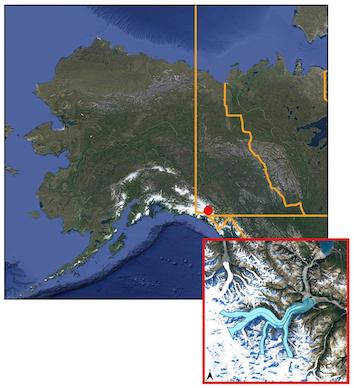

We want to choose an appropiate point to help us visualize, map, and compare a variety of imagery, as well as the results of our scripts, where we will be using comparisons to demonstrate some important characteristics of SAR imagery for cryospheric research. The point we have chosen is mid-way up the glacier, near the equilibrium line, and in the middle of the glacier.


In [5]:
# Set a point on the Kaskawulsh Glacier (mid-glacier) for filtering purposes
kask_gl = ee.Geometry.Point(-139.013173, 60.755079)

###Why chose SAR?

There are many times when SAR is a better choice than optical imagery.  It can be very difficult to distinguish between land and ice in the winter images, even if we have chosen the most cloud-free imagery. Synthetic Aperture Radar (SAR) is often used for ice-related topics as research areas are often located in areas with limited season light (i.e. the Arctic), heavy cloud cover, and relatively small optical differences between ice and snow. The active microwave sensor is able to penetrate cloud cover, does not rely on sunlight for acquisition, and carries a distinct and recognizably different response between water, snow, ice, and land.



#### Notable SAR Parameters
There are a few parameters in the metadata worth noting, as they are the main filters we use to choose specific imagery:

1.   IMAGE_DATE
2.   instrumentSwath
3.   orbitProperties_pass  
4.   transmitterReceiverPolarisation

Sentinel-1 collections C-band imagery, which penetrates surface materials, which means that as glacier surface conditions change seasonally, acquired imagery will differ due to changes on the glacier surface. For example, as spring hits, snow accumulated on the surface will start to melt, which increases the water content of the surface materials and returns dark. Winter, on the other hand, tends to accumulate dry snow, which returns on the white and light gray. In either instance, C-band pentrates enough to distinguish the underlying materials (i.e. rock vs. ice). This is important later when looking at surface response along the glacier, which also exhibits an elevation gradient.



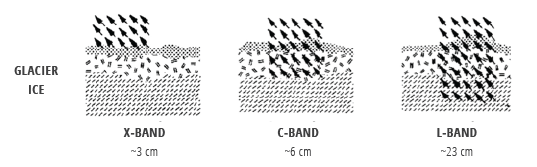

Surface roughness and dielectic properties (if and how deep the microwaves penetrate) are two parameters that influence the amount of backscatter returned to the sensor and the return presented in the imagery.

Once we know this, we can look at SAR imagery and make some conclusions about glacier surface conditions. Other techniques can be applied to capture ice motion using the particular patterns of backscatter unique to each pixel ('speckletracking'). For now, we will focus on the static imagery.




In [6]:
#load an image collection comprised of Sentinel 1 imagery
# ee.ImageCollection("COPERNICUS/S1_GRD")

In [7]:
# Filter Sentinel 1 Collection by metadata properties
  # Filter to get images with VV polarization
  # Filter to get images collected in interferometric wide swath mode
  # Filter to get images in ascending orbit
s1_col =  ee.ImageCollection('COPERNICUS/S1_GRD')\
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
              .filter(ee.Filter.eq('instrumentMode', 'IW'))\
              .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# Filter the collection by and location. Here, we are looking at a summer image
s1_img_VV_summer = s1_col.filterBounds(kask_gl)\
                  .filterDate('2018-06-01','2019-08-30')\
                  .first()# Choose first image in collection

s1_img_VV_summer_old = s1_col.filterBounds(kask_gl)\
                  .filterDate('2015-06-01','2015-08-30')\
                  .first()# Choose first image in collection

# Print image properties
imageprops = geemap.image_props(s1_img_VV_summer_old)
imageprops.getInfo()

{'GRD_Post_Processing_facility_country': 'United Kingdom',
 'GRD_Post_Processing_facility_name': 'UPA_',
 'GRD_Post_Processing_facility_org': 'Aibus DS',
 'GRD_Post_Processing_facility_site': 'Farnborough',
 'GRD_Post_Processing_software_name': 'Sentinel-1 IPF',
 'GRD_Post_Processing_software_version': '002.43',
 'GRD_Post_Processing_start': 1433151286180,
 'GRD_Post_Processing_stop': 1433151680000,
 'IMAGE_DATE': '2015-06-01',
 'NOMINAL_SCALE': {'VV': 10.0003, 'angle': 16044.292913500352},
 'S1TBX_Calibration_vers': '6.0.4',
 'S1TBX_SAR_Processing_vers': '6.0.4',
 'SLC_Processing_facility_country': 'United Kingdom',
 'SLC_Processing_facility_name': 'UPA_',
 'SLC_Processing_facility_org': 'Aibus DS',
 'SLC_Processing_facility_site': 'Farnborough',
 'SLC_Processing_software_name': 'Sentinel-1 IPF',
 'SLC_Processing_software_version': '002.43',
 'SLC_Processing_start': 1433151416000,
 'SLC_Processing_stop': 1433151608000,
 'SNAP_Graph_Processing_Framework_GPF_vers': '6.0.4',
 'cycleNumbe

In [8]:
# Display Sentinel 1 image on map
Map = geemap.Map()
Map.centerObject(kask_gl, 13)
Map.addLayer(s1_img_VV_summer, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image')
Map.addLayer(s1_img_VV_summer_old, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_older')
Map

Map(center=[60.75507900000001, -139.013173], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

Once again, this is a summer image. Let's compare it with a winter SAR image.

In [9]:
# Filter the collection by and location for winter imagery
s1_img_VV_winter = s1_col.filterBounds(kask_gl)\
                  .filterDate('2019-11-01', '2020-04-01')\
                  .first()# Choose first image in collection


In [10]:
# Display images on a map for comparison
Map = geemap.Map()

Map.centerObject(kask_gl, 13)

Map.addLayer(s1_img_VV_summer, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_summer')
Map.addLayer(s1_img_VV_winter, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_winter')

Map.addLayerControl()
Map

Map(center=[60.75507900000001, -139.013173], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

You will notice that the summer image has a lot more dark areas, whereas the winter image has more light areas, particularly in the upper reaches of the glacier. Seasonal differences in surface materials and their properties are the main reasons behind these differences.

#Surface properties and their impacts


# Backscatter
SAR imagery measures how much of the transmitted signal is scattered or absorbed by the surface materials (backscatter) and returned to the sensor (the 'return'). The two main factors that influence backscatter are:

1.   Roughness
2.   Dielectric properties


### A note on Speckle and Lee Filters
Materials scatter the transmitted signal and often there are other surfaces in the same pixel causing the signal to bounce around, creating 'speckle' or the salt and pepper pattern that underlies most areas. If you zoom into the previous image, you will notice the grainy appearance of the image which is the speckle.

We can apply a filter to the image to help reduce noise. The Lee filter uses local statistics to 'despeckle' the images. Applying such a filter will make flat surfaces appear more smooth, but edges are hard to maintain. We could adjust the window size (the area taken into account when caluclating the statistics). Smaller window sizes are better for more heterogenous areas like these mountains, where the measurements can varying dramatically over a small area. There are also newer versions of the Lee filter than the one we apply here.

In [11]:
# Set a point on the Kaskawulsh Glacier (mid-glacier) for filtering purposes
kask_gl = ee.Geometry.Point(-139.013173, 60.755079)

# Import sentinel 1 and filter data series according to location and date
s1_img_VV_lee =  ee.ImageCollection('COPERNICUS/S1_GRD') \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .filterBounds(kask_gl) \
                .filterDate('2018-06-01','2019-08-30') \

collection_asc = s1_img_VV_lee.map(RefinedLee)

In [12]:
# Display unfiltered and filtered images on a map for comparison
Map = geemap.Map()

S1_vis = {
  'bands': ['filter'],
  'min': -20,
  'max': 0,
  'gamma': 1.4,
}

Map.addLayer(s1_img_VV_summer, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_summer')
Map.addLayer(collection_asc.first(), S1_vis, "S1_VV_summer_Filtered")
Map.centerObject(kask_gl, 12)

Map

Map(center=[60.75507900000001, -139.013173], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

Pan around and notice areas of homogeneity and heterogeneity. In areas of homogeneity, the Lee filter does a great job of highlighting distinct features. However, in areas of heterogeneity (such as mountainous regions), the filter is less useful. This would be where we could play around with the window size to find one that maximizes the features without losing detail.

## Flat vs. Rough

Increased roughness increases the backscatter return, as the waves are redirected in multiple directions and the amount of signal returned to the sensor is limited. This results in flat surfaces appearing dark in the imagery, while rough areas (which can include ocean surfaces broken up by waves) appear light.


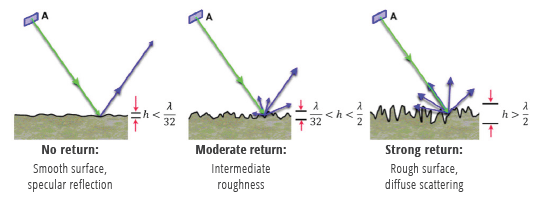

Let's load up a summer SAR image so that we can see the difference between the glacier surface, the surrounding rock materials, and Kluane Lake to the northeast.

In [13]:
# Create point in the wet zone to focus our map
kask_wet = ee.Geometry.Point(-138.59, 60.81)

Map = geemap.Map(width = 1000, height = 750)
Map.addLayer(s1_img_VV_summer, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_summer')

Map.centerObject(kask_wet, 9)
Map

Map(center=[60.81000000000001, -138.59], controls=(WidgetControl(options=['position', 'transparent_bg'], widge…

If you look to the northeast, you can see a large dark area, which is Kluane Lake. Because it is a lake, it is a mostly flat surface and water absorbs the signal. If you zoom into Kluane Lake, you might notice small areas that have more noticable speckle. This is caused by surface wave action created by the wind and a more rough surface at the time of acquisition. This can be an important factor in other regions, such as ocean-terminating glaciers.

Zoom in to examine the terminus of this land-based glacier. Notice the dark response of what we know to be water bodies, particularly the pro-glacial and supraglacial ponds and lakes, a stark contrast to bare ice.

## Wet vs Dry

In that same image, notice that the upper reaches of the glacier surface (to the southeast) look similar to the lake surface. These are areas of saturated melting snow, so they act similar to water. The lower reaches of the glacier are slightly lighter, as these regions are bare ice with a thin layer of meltwater on top.

Figure source: Arigony-Neto (2009) *Spatial and temporal changes in dry-snow line altitude on the Antarctic Peninsula.* Climatic Change 94(1):19-33

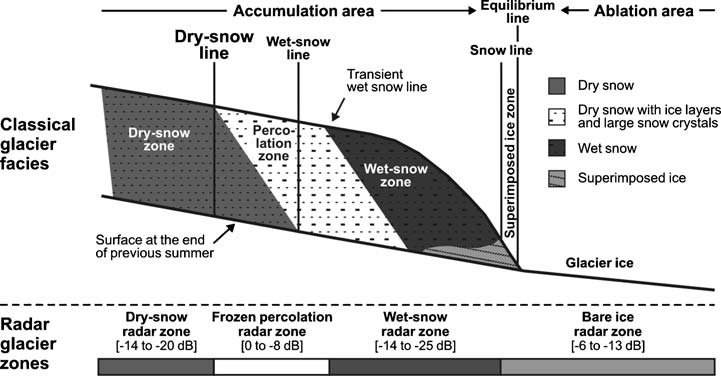

One advantage of SAR is that it can be used to differentiate amongst areas where there is bare ice, where the snow and ice is actively melting, and where the snow and ice remain frozen or dry. These lines are important when calculating the mass balance of glaciers and to examine the effects of climate change on glacier melt.

Remember that the signal is penetrating the surface materials, so the scatter seen here is caused by the surface materials as well as scatter caused by the underlying materials, which is why the Dry Snow Zone response appears similar to the Wet Snow Zone response. Basically, with dry snow, we are seeing both the response from the snow surface and the response from the underlying ice surface. Of course, the roughness of these surfaces also comes into play.

In [14]:
# Pick a point in the wet zone for comparison
kask_dry = ee.Geometry.Point(-139.1666, 60.7202)

# Filter the collection by and location for winter imagery
s1_img_VV_spring = s1_col.filterBounds(kask_gl)\
                  .filterDate('2019-03-15', '2020-06-15')\
                  .first()# Choose first image in collection

Map = geemap.Map()
Map.addLayer(s1_img_VV_spring, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_winter')
Map.centerObject(kask_dry, 13)
Map

Map(center=[60.720200000000006, -139.1666], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

#Ascending vs Descending

Spaceborne SAR imagery is acquired on both ascending and descending orbital paths. This important to note, since the angle at which the imagery is acquired impacts the pattern of the backscatter. This is noticable if you compare two images (below).

To compare images at the same location we need to compare apples to apples (in this case: ascending to ascending OR descending to descending) or apply terrain corrections prior to further analysis if we wanted to mix images from the two orbital paths.  

In [15]:
# Filter Sentinel 1 Collection by metadata properties
  # Filter to get images with VV polarization
  # Filter to get images collected in interferometric wide swath mode
  # Filter to get images in ascending orbit
s1_col_A =  ee.ImageCollection('COPERNICUS/S1_GRD')\
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
              .filter(ee.Filter.eq('instrumentMode', 'IW'))\
              .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# Filter the collection by date and location
s1_img_VV_winter_asc = s1_col_A.filterBounds(kask_gl)\
                  .filterDate('2019-11-01', '2020-04-01')\
                  .first() # Choose first image in collection

  # Filter to get images with VV polarization
  # Filter to get images collected in interferometric wide swath mode
  # Filter to get images in ascending orbit
s1_col_D =  ee.ImageCollection('COPERNICUS/S1_GRD')\
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
              .filter(ee.Filter.eq('instrumentMode', 'IW'))\
              .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

# Filter the collection by date and location
s1_img_VV_winter_desc = s1_col_D.filterBounds(kask_gl)\
                  .filterDate('2019-11-01', '2020-04-01')\
                  .first()# Choose first image in collection


In [16]:
# Display images on map
Map = geemap.Map()
Map.centerObject(kask_gl,8)
Map.addLayer(s1_img_VV_winter_asc, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_asc')
Map.addLayer(s1_img_VV_winter_desc, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_dsc')
Map

Map(center=[60.75507900000001, -139.013173], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

Notice how the mountains appear to shift when comparing the images. This is a result of the angle from which the images are acquired (the look angle). The look angle can have three main impacts on the resulting image:

1.   Foreshortening
2.   Layover
3.   Shadow

These concerns have particularly noticable impacts in mountainous areas, such as the St. Elias Range. Keep in mind that glaciers are often curvi-linear features, can be oriented along, parallel, or oblique to the orbital path, so you may choose your imagery differently depending on your AOI and the type of analysis you are performing. Flat areas, with little relief, are not as heavily influenced by these challenges, but thinking about them beforehand can save some mis-interpretations. There are some corrections that can be applied to help adjust this.

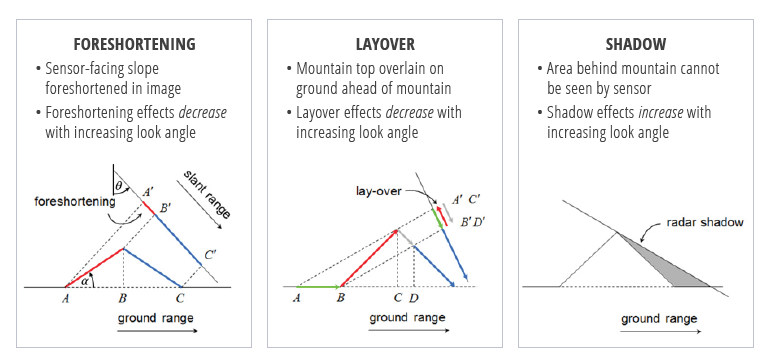

First, let's look at a hillshade and a relevent DEM to see what is actually happening on the ground. Then we will compare it to an uncorrected image to see what these errors look like.

In [17]:
# A script for visualizing a hillshade based on
# the Arctic DEM to help demonstrate the effects of layover, foreshortenting, and shadow
# https://developers.google.com/earth-engine/datasets/catalog/UMN_PGC_ArcticDEM_V3_2m_mosaic

kask_DEM = ee.Image('UMN/PGC/ArcticDEM/V3/2m_mosaic')

# Hillshade for better visualization
exaggeration = 50
azimuth = 60
hillshade = ee.Terrain.hillshade(kask_DEM.multiply(exaggeration))


In [18]:
# Display image on map with the S1 image underneath and a DEM overlain
Map = geemap.Map()

DEM_vis = {
  'bands': ['elevation'],
  'min': 0,
  'max' : 5000,
  'palette': ['0000ff', '00ffff', 'ff0000' ]
}

#, 'fbff00', '8D33FF', '33FF4F', 'DDFF33', 'A233FF', '33C4FF'
HS_vis = {
  'bands': ['hillshade'],
  'palette': ['fbff00', '00ffff', 'ff0000' ]
}

Map.centerObject(kask_gl, 13)
Map.addLayer(hillshade, HS_vis, 'Arctic_DEM Hillshade')
Map.addLayer(kask_DEM, DEM_vis, 'kask_DEM', opacity = 0.5)

Map


Map(center=[60.75507900000001, -139.013173], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

In [19]:
# Filter the collection by date and location for a summer image
s1_img_VV_summer = s1_col_D.filterBounds(kask_gl)\
                  .filterDate('2019-04-01', '2020-08-01')\
                  .first() # Choose first image in collection

In [20]:
# Compare an uncorrected S1 image to the hillshade based on the Arctic DEM
Map = geemap.Map()

HS_vis = {
  'bands': ['hillshade'],
  'palette': ['fbff00', '00ffff', 'ff0000' ]
}

Map.addLayer(s1_img_VV_summer, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_VV')
Map.addLayer(hillshade, HS_vis, 'Arctic_DEM Hillshade', opacity = 0.5)
Map.centerObject(kask_gl, 13)

Map


Map(center=[60.75507900000001, -139.013173], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

If we take a closer look at some of these areas, you will notice mis-matches between the hillshade (colour) and the underlying S1 image (gray scale). In the map below we zoom into a ridge where some mismatch is happening. By flipping between the hillshade and S1 image you can see that the ridgeline does not quite match up between the two layers.

In [21]:
Map = geemap.Map()

mismatch = ee.Geometry.Point(-139.0544,60.7944)

HS_vis = {
  'bands': ['hillshade'],
  'palette': ['fbff00', '00ffff', 'ff0000' ]
}

Map.addLayer(s1_img_VV_summer, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_VV')
Map.addLayer(hillshade, HS_vis, 'Arctic_DEM Hillshade', opacity = 0.5)
Map.addLayer(mismatch, {},'Mismatched Ridge')

Map.addLayerControl()
Map.centerObject(mismatch, 14)
Map

Map(center=[60.7944, -139.0544], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

The function used here (adapted from an implementation by Andreas Vollrath (ESA)) produces masks of areas of shadow and layover using the Arctic DEM as a base. Run the code below, then turn off the various layers to see the areas of layover and shadow are identified in this region.

In [23]:
Map = geemap.Map()

# Set a point on the Kaskawulsh Glacier (mid-glacier) for filtering purposes
kask_gl = ee.Geometry.Point(-139.013173, 60.755079)

# import sentinel 1 and filter by mode, polarization date and bounds
# adapted from an implementation by Andreas Vollrath (ESA)
s1_stack =  ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filterBounds(kask_gl) \
    .filterDate('2018-06-01','2018-08-30')


# make a subset of just the ascending mode images
s1_stack_asc =  s1_stack \
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# make a subset of just the descending mode images
s1_stack_desc =  s1_stack \
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

# We call the terrainCorrection function we lined up at the beginning of the lab
corrected_asc = s1_stack_asc.map(terrainCorrection)
corrected_desc = s1_stack_desc.map(terrainCorrection)

S1_vis = {
  'bands': ['VV'],
  'min': -20,
  'max': 0,
  'gamma': 1.4,
}

S1_layover = {
    'bands': ['layover'],
    'palette': ['ff0000', 'f1c232']
}

S1_shadow = {
    'bands': ['shadow'],
    'palette': ['ff0000', 'f1c232']
}
#image = image.mask(image.mask().where(image.eq(0),0.0))
# medianWinterMask = medianWinter.gt(0.4)

Map.addLayer(s1_stack_desc.first(), S1_vis, "original descending")
Map.addLayer(corrected_desc.first(), S1_vis, "corrected descending")
Map.addLayer(corrected_desc.first(), S1_layover, "layover descending", opacity = 0.5)
Map.addLayer(corrected_asc.first(), S1_shadow, "shadow descending", opacity = 0.5)

Map.addLayerControl()
Map.centerObject(kask_gl,10)
Map


Map(center=[60.75507900000001, -139.013173], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

**Notice the areas of concern (in red) we have identified.** For the most part they are areas near the ridgelines of mountains, which makes sense when we look at the diagrams above. The peaks of mountains cause interruptions in the signal that can be corrected for.

Since there is a large impact on the signal, we always need to make sure we are comparing similarly acquired images or are applying appropriate terrain corrections before performing any complex analyses.

#Polarization

SAR imagery also contains information on the state of the wave as it leaves the sensor and then is returned.

Thus far, we have been looking at VV (vertical transmission, vertical return), where the signal is returned to the sensor in the same plane as it is transmitted. VH (vertical transmission, horizontal return) and HH (horizontal transmission, horizontal return) are also possibilities.

We choose which polarization to use in order to optimize for the materials of interest or for the technique we want to use. Similar to the ascending/descending discussion, we need to assess the polarization options prior to further analysis.

Now let's compare the VV and VH polarized images from the above dates.

In [24]:
# Filter Sentinel 1 Collection by metadata properties
  # Filter to get images with VH polarization
  # Filter to get images collected in interferometric wide swath mode
  # Filter to get images in ascending orbit
s1_col_VH =  ee.ImageCollection('COPERNICUS/S1_GRD')\
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
              .filter(ee.Filter.eq('instrumentMode', 'IW'))\
              .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# Filter the collection by and location
s1_img_VH = s1_col_VH.filterBounds(kask_gl)\
                  .filterDate('2018-04-01','2019-05-31')\
                  .first()# Choose first image in collection

# Filter to get images with VV polarization
# Filter to get images collected in interferometric wide swath mode
# Filter to get images in ascending orbit
s1_col_VV =  ee.ImageCollection('COPERNICUS/S1_GRD')\
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
              .filter(ee.Filter.eq('instrumentMode', 'IW'))\
              .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# Filter the collection by and location
s1_img_VV = s1_col_VV.filterBounds(kask_gl)\
                  .filterDate('2018-04-01','2019-05-31')\
                  .first() # Choose first image in collection

We're going to add a shapefile that outlines the Kaskwulsh Glacier so that we can easily pick out our AOI when we look at the VV and VH images.

First we need to mount our drive so that we can import files from it.

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
# If the path to your data is different than mine, you should change it
# Kask_outline = '/content/drive/My Drive/Kaskwulsh_outline.shp'
shp = 'C:/Users/cptci/OneDrive - Carleton University/Documents/GitHub/GEOG6006-qb/data/Kaskwulsh_outline/Kaskwulsh_outline.shp'
shpdata = geemap.shp_to_ee(shp)

# All the other extemsions which accompany the shapefile will be read as well
# shpdata = geemap.shp_to_ee(Kask_outline)

Let's compare the VH polarization with the previous VV polarization from the same AOI.

In [28]:
# Display image on map
Map = geemap.Map()

Map.centerObject(kask_gl,8)
Map.addLayer(s1_img_VV, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_VV')
Map.addLayer(s1_img_VH, {'bands': ['VH','VH','VH'], 'min': -20,'max': 0},'S1-image_VH')
SHPViz = {
  'color': 'blue'
  }

# Defining the opacity argument of the addLayer function
# We want the shpdata layer to be easy to see through
shown = True
opacity = 0.25

Map.addLayer(shpdata, SHPViz, 'shpdata', shown, opacity)

Map

Map(center=[60.75507900000001, -139.013173], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

#Questions to Submit

Answer the following questions in the space provided. Feel free to add additional code and text cells as needed. Make sure to show all of your code.

In all cases, if you use code chunks from another source (not a bad thing), make sure to reference where you found them.


## Q1

We compared Sentinel 1 imagery from the summer (July) and the winter (January). Include code to look at the same site in spring (April) and fall (October) and compare the images in the same map. Do they show similar patterns? How do the two images differ? Explain and interpret.

In [29]:
s1_col =  ee.ImageCollection('COPERNICUS/S1_GRD')\
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
              .filter(ee.Filter.eq('instrumentMode', 'IW'))\
              .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# Filter the collection by and location. Here, we are looking at a summer image
s1_img_VV_spring = s1_col.filterBounds(kask_gl)\
                  .filterDate('2019-04-01','2019-04-30')\
                  .first()# Choose first image in collection

# Filter the collection by and location for winter imagery
s1_img_VV_autumn = s1_col.filterBounds(kask_gl)\
                  .filterDate('2019-10-01', '2019-10-30')\
                  .first()# Choose first image in collection


# Display images on a map for comparison
Map = geemap.Map()

Map.centerObject(kask_gl, 13)

Map.addLayer(s1_img_VV_spring, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_spring')
Map.addLayer(s1_img_VV_autumn, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1-image_autumn')

Map.addLayerControl()
Map

Map(center=[60.75507900000001, -139.013173], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

The spring image is generally lighter than the autumn image, probably because of increased snow water content in the fall when the glacier is at its minimum extent. The lateral moraines are brighter in the fall, maybe because surface snow has melted and exposed rougher ice, but the water has flowed off of these raised ridges so a strong response is preserved.

## Q2
Looking at the same images, there are strips on the glacier that are appear white in the image. Comparing the SAR imagery with Landsat or Sentinel-2 imagery.  Based on visual interpretation, what are these features and why might they appear white in the SAR data? Include code that compares the Landsat Mosaic with at least one SAR image.

If you're unfamiliar with glacial landforms, check out the information at this link to help you: https://nsidc.org/cryosphere/glaciers/gallery/grooves.html

In [30]:
kask_gl = ee.Geometry.Point(-139.013173, 60.755079)
kask_gl = ee.Geometry.Point(-75.701271, 45.3)

#Note I tried this exercise on Gatineau instead


# Load all Sentinel 2 Surface Reflectance images from June 2019
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR')\
                  .filterDate('2021-08-01', '2021-08-31')\
                  .filterBounds(kask_gl)\
                  .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',30))\
                  .sort('CLOUDY_PIXEL_PERCENTAGE')\
                  .first()

#Sentinel 1 SAR
s1_col =  ee.ImageCollection('COPERNICUS/S1_GRD')\
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
              .filter(ee.Filter.eq('instrumentMode', 'IW'))\
              .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
# Filter the collection by and location for winter imagery
s1_img_VV = s1_col.filterBounds(kask_gl)\
                  .filterDate('2021-08-01', '2021-08-31')\
                  .first()# Choose first image in collection

# Hillshade for better visualization
DEM = ee.ImageCollection("NRCan/CDEM")\
                  .filterBounds(kask_gl)\

exaggeration = 50
azimuth = 60
DEM = DEM.mean()
hillshade = ee.Terrain.hillshade(DEM.multiply(exaggeration))

HS_vis = {
  'bands': ['hillshade'],
  'palette': ['fbff00', '00ffff', 'ff0000' ]
}

# Set the visualization parameters for the image
visParams = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000
}

# Display images on a map for comparison
Map = geemap.Map()
Map.centerObject(kask_gl, zoom=11)

Map.addLayer(sentinel2, visParams, 'Sentinel-2 Visual')
Map.addLayerControl()

Map.addLayer(s1_img_VV, {'bands': ['VV','VV','VV'], 'min': -20,'max': 0},'S1 SAR')
Map.addLayerControl()

Map.addLayer(hillshade, HS_vis, 'Gatineau Hillshade')

Map

Map(center=[45.3, -75.701271], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

## Q3

We looked at potential errors introduced into our SAR imagery, particularly in mountainous regions (layover, shadow, foreshortening), then we performed a terrain correction on the imagery using a descending image. Write code to perform a similar correction but on an ascending image.

Using what we discussed about foreshortening, shadow and layover, compare and contrast the two images. Are the results similar to the descending example in the lab? Are there more corrections needed in certain areas?

In [31]:
Map = geemap.Map()

# Set a point on the Kaskawulsh Glacier (mid-glacier) for filtering purposes
kask_gl = ee.Geometry.Point(-139.013173, 60.755079)

# import sentinel 1 and filter by mode, polarization date and bounds
# adapted from an implementation by Andreas Vollrath (ESA)
s1_stack =  ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filterBounds(kask_gl) \
    .filterDate('2018-06-01','2018-08-30')


# make a subset of just the ascending mode images
s1_stack_asc =  s1_stack \
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# make a subset of just the descending mode images
s1_stack_desc =  s1_stack \
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

# We call the terrainCorrection function we lined up at the beginning of the lab
corrected_asc = s1_stack_asc.map(terrainCorrection)
corrected_desc = s1_stack_desc.map(terrainCorrection)

S1_vis = {
  'bands': ['VV'],
  'min': -20,
  'max': 0,
  'gamma': 1.4,
}

S1_layover = {
    'bands': ['layover'],
    'palette': ['ff0000', 'f1c232']
}

S1_shadow = {
    'bands': ['shadow'],
    'palette': ['ff0000', 'f1c232']
}
#image = image.mask(image.mask().where(image.eq(0),0.0))
# medianWinterMask = medianWinter.gt(0.4)

Map.addLayer(s1_stack_desc.first(), S1_vis, "original descending")
Map.addLayer(corrected_desc.first(), S1_vis, "corrected descending")
Map.addLayer(corrected_desc.first(), S1_layover, "layover descending", opacity = 0.5)
Map.addLayer(corrected_desc.first(), S1_shadow, "shadow descending", opacity = 0.5)

Map.addLayer(s1_stack_asc.first(), S1_vis, "original ascending")
Map.addLayer(corrected_asc.first(), S1_vis, "corrected ascending")
Map.addLayer(corrected_asc.first(), S1_layover, "layover ascending", opacity = 0.5)
Map.addLayer(corrected_asc.first(), S1_shadow, "shadow ascending", opacity = 0.5)

Map.addLayerControl()
Map.centerObject(kask_gl,10)
Map

Map(center=[60.75507900000001, -139.013173], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

The two images are similar but mirrored, so that in the ascending image, the layover is worse on southern and west aspects and absent on northern and east aspects, but in the descending image this pattern in switched. Similarly, the shadow is worse on the north/west side (ascending), and south/east side (descending).